In [ ]:
!pip install --upgrade statsmodels  dask[dataframe] xgboost

In [ ]:
import pandas as pd
import dask.dataframe as dd
from enum import unique
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet import Prophet  # or "from prophet import Prophet" if using the new package name
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Masking
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.18.0
[]


In [ ]:
# Connecting to googledrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ruta = '/content/drive/MyDrive/postulaciones/celes_test/df_preprocess_lstm.parquet'
df = dd.read_parquet(ruta,
                     parse_dates=["Year-Month"],
                     engine = 'pyarrow'
                 )
df['Year-Month'] = dd.to_datetime(df['Year-Month'], format='%Y-%m-%d')
# Sort by Date to maintain time series order
df = df.sort_values("Year-Month").persist()

# Verify sorting
df.shape[0].compute()

179775

In [ ]:
df.head()

,Year-Month,ProductID,StoreID,Quantity,Promotion,Price,Price_Promo
0,2022-08-01,80,60,1432.1934,0.0,8.218260,8.218260
11,2022-08-01,236,72,518.0274,0.0,2320.138687,2320.138687
1,2022-08-01,49,159,2.7702,0.0,2646.464400,2646.464400
2,2022-08-01,112,14,7458.3018,0.0,7.294860,7.294860
3,2022-08-01,259,159,117.2718,0.0,5811.879600,5811.879600


In [ ]:
# Feature scaling (normalize numerical features)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Quantity', 'Price', 'Promotion', 'Price_Promo']])

In [ ]:
df = df.compute()

### Predictions with promotions

In [ ]:
# Convert dataframe back after scaling
df[['Quantity', 'Price', 'Promotion', 'Price_Promo']] = scaled_data

In [ ]:
def create_dynamic_sequences(df, min_steps=3, with_promo=True):
    """
    Create sequences with variable n_steps per (ProductID, StoreID).
    Sequences with less than `min_steps` observations are ignored.
    """
    sequences = []

    for (product, store), group in df.groupby(["ProductID", "StoreID"]):
        group = group.sort_values("Year-Month")  # Ensure correct order
        available_steps = len(group)

        # Use min(available_steps, max_n_steps) as n_steps
        n_steps = min(available_steps, 12)

        # Skip sequences that don't have the minimum required steps
        if n_steps < min_steps:
            continue
        if with_promo:
            data_values = group[['Quantity', 'Price', 'Promotion', 'Price_Promo']].values
        else:
            data_values = group[['Quantity', 'Price']].values

        # Create sequences for this product-store pair
        for i in range(len(data_values) - n_steps):
            X_seq = data_values[i:i+n_steps, :]
            y_seq = data_values[i+n_steps, 0]  # Target = Quantity
            sequences.append((X_seq, y_seq))

    # Convert to numpy arrays
    X, y = zip(*sequences)
    return np.array(X), np.array(y)

In [ ]:
# Apply function
X, y = create_dynamic_sequences(df)
print("Final dataset shape:", X.shape, y.shape)

Final dataset shape: (67711, 12, 4) (67711,)


In [ ]:
# Train-test split (80% train, 20% test)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
def model_lstm(X):
    # Build LSTM Model
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(None, X.shape[2])),
        Dropout(0.2),
        LSTM(50, activation='relu', return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)  # Output layer (predicting 'Quantity')
    ])

    # Compile Model
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
model = model_lstm(X)

In [ ]:
# Train Model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

Epoch 1/5
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - loss: 3.2645e-04
Epoch 2/5
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - loss: 2.2354e-05
Epoch 3/5
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 43s 20ms/step - loss: 2.6761e-05
Epoch 4/5
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 33s 15ms/step - loss: 1.8263e-05
Epoch 5/5
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - loss: 1.4495e-05


In [ ]:
# Make Predictions
y_pred = model.predict(X_test)

# Rescale predictions back to original scale
y_test_original = scaler.inverse_transform(np.column_stack((y_test, np.zeros((y_test.shape[0], 3)))))[:, 0]
y_pred_original = scaler.inverse_transform(np.column_stack((y_pred.flatten(), np.zeros((y_pred.shape[0], 3)))))[:, 0]

424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


In [ ]:
# Calculate Evaluation Metrics
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Error (MAE): 65.1913
Root Mean Squared Error (RMSE): 203.8600


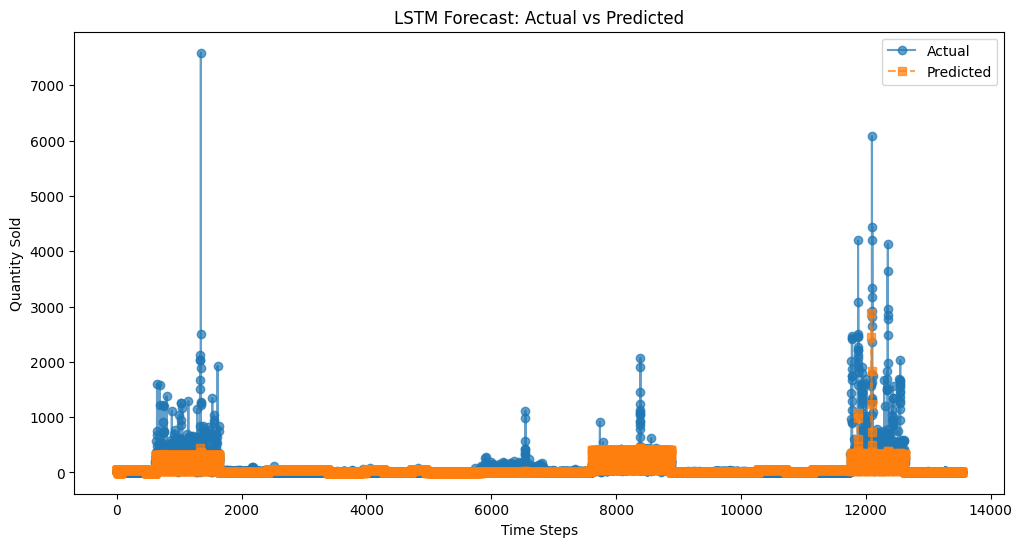

In [ ]:
# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Actual", marker='o', linestyle="-", alpha=0.7)
plt.plot(y_pred_original, label="Predicted", marker='s', linestyle="--", alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("Quantity Sold")
plt.title("LSTM Forecast: Actual vs Predicted")
plt.legend()
plt.show()

### Predictions without promotions

In [ ]:
df_out_promotions = df.drop(columns=['Promotion', 'Price_Promo'], axis = 1)
df_out_promotions.head()

,Year-Month,ProductID,StoreID,Quantity,Price
0,2022-08-01,80,60,0.009141,0.000227
11,2022-08-01,236,72,0.003304,0.070582
1,2022-08-01,49,159,0.000014,0.080512
2,2022-08-01,112,14,0.047616,0.000199
3,2022-08-01,259,159,0.000745,0.176839


In [ ]:
# Apply function
X_out, y_out = create_dynamic_sequences(df_out_promotions, with_promo= False)
print("Final dataset shape:", X_out.shape, y_out.shape)

Final dataset shape: (67711, 12, 2) (67711,)


In [ ]:
# Train-test split (80% train, 20% test)
split = int(len(X) * 0.8)
X_train_out, X_test_out = X_out[:split], X_out[split:]
y_train_out, y_test_out = y_out[:split], y_out[split:]

In [ ]:
model_out = model_lstm(X_out)

<ipython-input-47-92eb4fc715a9>:4: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  LSTM(50, activation='relu', return_sequences=True, input_shape=(None, X.shape[2])),


In [ ]:
# Train Model
history_out = model_out.fit(X_train_out, y_train_out, epochs=5, batch_size=32, verbose=1)

Epoch 1/5
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - loss: 3.0290e-05
Epoch 2/5
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 55s 24ms/step - loss: 6.0611e-05
Epoch 3/5
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - loss: 1.7731e-05
Epoch 4/5
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - loss: 4.9433e-05
Epoch 5/5
1693/1693 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - loss: 3.1697e-05


In [ ]:
# Make Predictions
y_pred_out = model_out.predict(X_test_out)

# Rescale predictions back to original scale
y_test_original_out = scaler.inverse_transform(np.column_stack((y_test_out, np.zeros((y_test_out.shape[0], 3)))))[:, 0]
y_pred_original_out = scaler.inverse_transform(np.column_stack((y_pred_out.flatten(), np.zeros((y_pred_out.shape[0], 3)))))[:, 0]

424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


In [ ]:
# Calculate Evaluation Metrics
mae_out = mean_absolute_error(y_test_original_out, y_pred_original_out)
rmse_out = np.sqrt(mean_squared_error(y_test_original_out, y_pred_original_out))

print(f"Mean Absolute Error (MAE): {mae_out:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_out:.4f}")

Mean Absolute Error (MAE): 494.1026
Root Mean Squared Error (RMSE): 516.1099


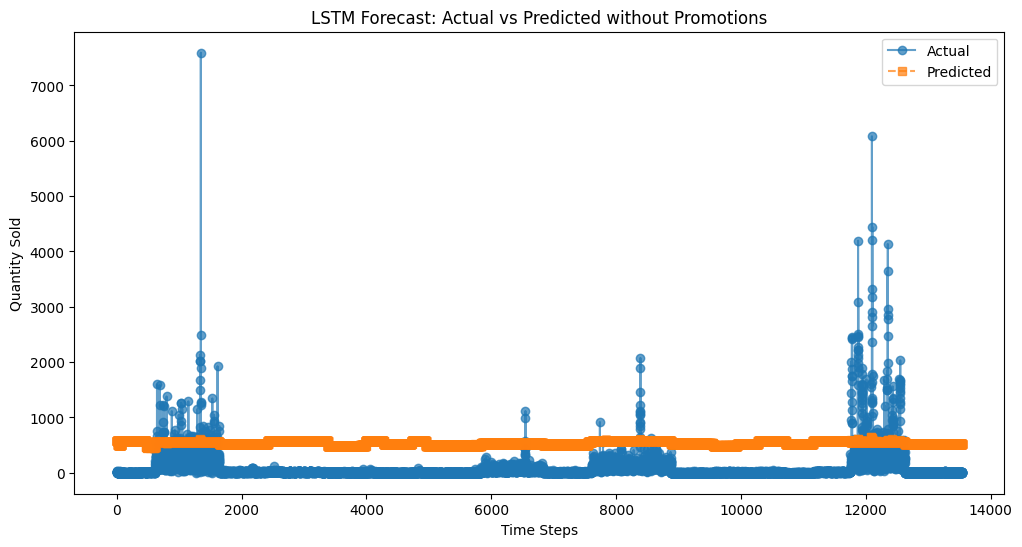

In [ ]:
# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original_out, label="Actual", marker='o', linestyle="-", alpha=0.7)
plt.plot(y_pred_original_out, label="Predicted", marker='s', linestyle="--", alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("Quantity Sold")
plt.title("LSTM Forecast: Actual vs Predicted without Promotions")
plt.legend()
plt.show()

### **Conclusions**
* Data with Promotions gets a better prediction.
* Some pairs **StoreID** and **ProductID** does not have complete data to create a prediction for 12 months later and this could affect the prediction.
* It is used MAE as a metric because it has the sames units as Quantity variable. It is used RMSE because gets an idea of atypical values in the data.
* It is possible to improve the model working in atypical values and creating lag variables and rolling variables.